# Model A PCA

In [1]:
import cv2
import re
import io
import os
import pickle
import zipfile
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from data_utils import read_files_from_zip, data2pd, show_balance

SIZE = 30

2024-04-26 10:03:18.653580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Configure system type
COLAB = False

# Set data and system paths
if COLAB:
  import sys
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/Colab Notebooks/grad_project'
  data_dir = f'{path}/data'
  sys.path.insert(0, f'{path}/Source') # for colab to see local libraries
else:
  data_dir = f'../data'

# Set Date Source
data_file = f'{data_dir}/sp24_grad_project_data.zip'

In [3]:
# Load Test Images
test_data_images = read_files_from_zip(data_file, r'(test)_images_([\w-]*)\.npz')

# Load Train Images and Labels
train_data_images = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_images\.npz')
train_data_labels = read_files_from_zip(data_file, r'satellite-image-data/([\w-]*)/(train)_labels\.npy')

# Convert to Dataframe
train_df = data2pd(train_data_images, train_data_labels)
test_df = data2pd(test_data_images)

# Clean up
del(test_data_images)
del(train_data_images)
del(train_data_labels)

Importing data from zip: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Found the following datasets:  ['hurricane-matthew', 'flooding-fire']


Importing data from zip: 100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']


Importing data from zip: 100%|██████████| 3/3 [00:00<00:00, 1478.95it/s]

Found the following datasets:  ['socal-fire', 'midwest-flooding', 'hurricane-matthew']


In [4]:
# Feature Engineering and Balance
"""
# Add a size column
def get_size(img):
    dim = img.shape
    return dim[0] * dim[1]
train_df['size'] = train_df['image'].apply(get_size)

# Show size feature and range
print(train_df.columns)
train_df[['size']].describe().T
"""

"\n# Add a size column\ndef get_size(img):\n    dim = img.shape\n    return dim[0] * dim[1]\ntrain_df['size'] = train_df['image'].apply(get_size)\n\n# Show size feature and range\nprint(train_df.columns)\ntrain_df[['size']].describe().T\n"

In [7]:
# Create dataset for Disaster Type Classification
classify_type_df = train_df[((train_df.type == 'fire') | (train_df.type == 'flood')) & (train_df.label != 0)]

show_balance(classify_type_df)
classify_type_df.shape

type   label
fire   3        1064
       1          69
       2          43
flood  1         114
       2          97
       3          59
Name: count, dtype: int64

(1446, 4)

In [9]:
"""

# We ought to try SMOTE instead but we wanted to try this manual approach first...
# We really need to squeeze out as much unique data as possible...
# because there isn't much to work with.
from feature_utils import augment_image

# This doesn't help for SVD but does for CNN
def get_validation_set(classify_type_df):
    sample_size = 8

    classify_type_valid_df = pd.DataFrame()
    print('Before: ',classify_type_df.shape)
    for T in classify_type_df.type.unique(): # T for type
        for L in classify_type_df.label.unique(): # L for label
            if (L==0):
                this_sample_size = sample_size//2
            else:
                this_sample_size = sample_size
            sample_df =  classify_type_df[
                    (classify_type_df['type'] == T) & (classify_type_df['label'] == L)
                    & ((classify_type_df['size'] <= 10240) & (classify_type_df['size'] >= 1936))
                ].sample(this_sample_size)
            classify_type_valid_df = pd.concat([sample_df, classify_type_valid_df])
    classify_type_df = classify_type_df.drop(index=classify_type_valid_df.index)
    return classify_type_valid_df, classify_type_df


# Now augment data until balanced.
# We'll use a mix of oversampling and undersampling...
# - oversample the minority class using replacement
# - undersample by randomly delete rows from the majority class to match
def get_train_set(classify_type_df, classify_type_valid_df):
    classify_type_train_df = pd.DataFrame()

    # Drop the validation set before sampling
    classify_type_df = classify_type_df.drop(index=classify_type_valid_df.index)

    # Set a reasonable argumentation limit
    sample_size = 150 #int(114 * 1.32)

    # We apply flip, rotate augmentation to the
    # sample with replacement samples.
    # We might duplicate an augmentation if the
    # same record is sampled and the augmentation
    # is applied.

    for T in classify_type_df.type.unique():
        for L in classify_type_df.label.unique():
            if L==0:
                this_sample_size = sample_size//2
            else:
                this_sample_size = sample_size
            record_size = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].shape[0]
            if (record_size > this_sample_size):
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(this_sample_size)
            else:
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)]
                classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
                sample_df = classify_type_df[(classify_type_df['type'] == T) & (classify_type_df['label'] == L)].sample(this_sample_size-record_size, replace=True)
                sample_df['image'] = sample_df['image'].apply(augment_image)
            classify_type_train_df = pd.concat([sample_df, classify_type_train_df])
    return classify_type_train_df


# Create dataset for Disaster Type Classification
#classify_type_df = train_df[((train_df.type == 'fire') | (train_df.type == 'flood'))]
classify_type_df = train_df[((train_df.type == 'fire') | (train_df.type == 'flood')) & (train_df.label != 0)]# exclude if no damage

# Sample a balance set for classifcation
classify_type_valid_df, classify_train_valid_df = get_validation_set(classify_type_df)
classify_type_train_df = get_train_set(classify_type_df, classify_type_valid_df)

print("Before: ")
show_balance(classify_type_df)

print("Test: ")
show_balance(classify_type_valid_df)
print("Train: ")
show_balance(classify_type_train_df)
""";

In [52]:
# Encode Labels and Resize Images for modeling.
import cv2

def encode_type(type_df, size=24, classifier='logistic', test=False):
    # size=19 is the default limit for logistic regression
    # 0:flood, 1:fire
    type_df = type_df.copy()
    if classifier=='logistic':
        type_df.loc[:, 'type_code'] = type_df[['type','label']].apply(
            lambda df: 1 if df['type']=='fire' else 0, axis=1
        )
    else:
        type_df['type_code'] = type_df[['type','label']].apply(
            lambda df: df['label'] if df['type']=='fire' else -df['label'], axis=1).astype('float')
        type_df['type_code'] = type_df['type_code']/type_df['type_code'].abs().max()
    X = type_df['image'].to_list()
    X = np.array([cv2.resize(img, (size, size)) for img in X])/255.0  # for positive definateness
    #X = np.array([cv2.resize(gabor_filter(img), (size, size)) for img in X])/255.0 # not very useful
    X = X.reshape((X.shape[0], -1)) # Flatten the images
    
    if test == True:
        return X
    else:
        Y = type_df['type_code']
        return X,Y

def encode_type_test(type_df, size=24, classifier='logistic'):
    assert classifier=='logistic', 'Only logit is supported'
    type_df = type_df.copy()
    X = type_df['image'].to_list()
    X = np.array([cv2.resize(img, (size, size)) for img in X])/255.0  # for positive definateness
    X = X.reshape((X.shape[0], -1)) # Flatten the images
    return X


## To Balance or Not? That is the question.  

In [28]:
#sklearn.model_selection.train_test_split
from sklearn.model_selection import train_test_split

# Encode and split the data into training and testing sets
USE_BALANCE = False
classifier='logistic'

X_train,X_valid, Y_train, Y_test = [],[],[],[]
if USE_BALANCE:
    X_valid, Y_test = encode_type(classify_type_valid_df, classifier=classifier)
    X_train, Y_train = encode_type(classify_type_train_df, classifier=classifier)
else:
    X, Y = encode_type(classify_type_df, classifier=classifier)
    X_train,X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

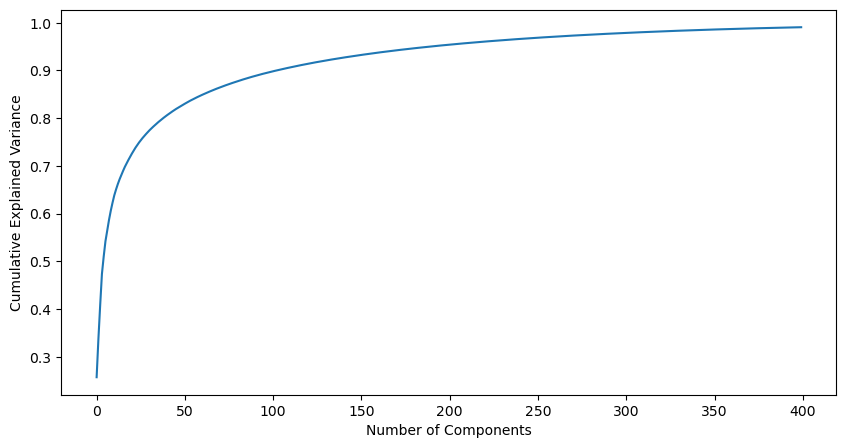

CPU times: user 4.2 s, sys: 1.57 s, total: 5.78 s
Wall time: 2.02 s


In [48]:
%%time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=400)
X_train_pca = pca.fit_transform(X_train)

# Plot the explained variance ratio
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [49]:
# Fit a classifier on the transformed data
clf= []
if classifier=='linear':
    clf = LinearRegression()
else:
    clf = LogisticRegression()
clf.fit(X_train_pca, Y_train)

# Transform the test data
X_valid_pca = pca.transform(X_valid)

# Make prediction
Y_pred = clf.predict(X_valid_pca)

"""
# Make predictions
def custom_activation(y):
    return np.where(y > 0, 1, 0)
    

if classifier=='linear':
    Y_pred = custom_activation(Y_pred)
    Y_test = custom_activation(Y_test)
"""

# Print the model prediction statistics
print("Precision: ", precision_score(Y_valid, Y_pred, average='weighted'))
print("Recall: ", recall_score(Y_valid, Y_pred, average='weighted'))
print("F1 Score: ", f1_score(Y_valid, Y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(Y_valid, Y_pred))

Precision:  0.8487267598919435
Recall:  0.8586206896551725
F1 Score:  0.8492312495233398
Accuracy:  0.8586206896551725


In [53]:
# Transform the test data
#X_test = encode_type(classify_type_df, classifier=classifier, test=True)

X_test = test_df[(test_df.type == 'fire') | (test_df.type == 'flood')]

X_test = encode_type_test(X_test, classifier=classifier)

X_test_pca = pca.transform(X_test)

# Make predictions
Y_pred = clf.predict(X_test_pca)

# Submit our prediction
Y_pred

Y_pred_out = pd.DataFrame(Y_pred, columns=['pred'])
Y_pred_out.to_csv('test_images_flooding-fire_predictions.csv', index=False)

In [54]:
Y_pred_out.shape

(3847, 1)

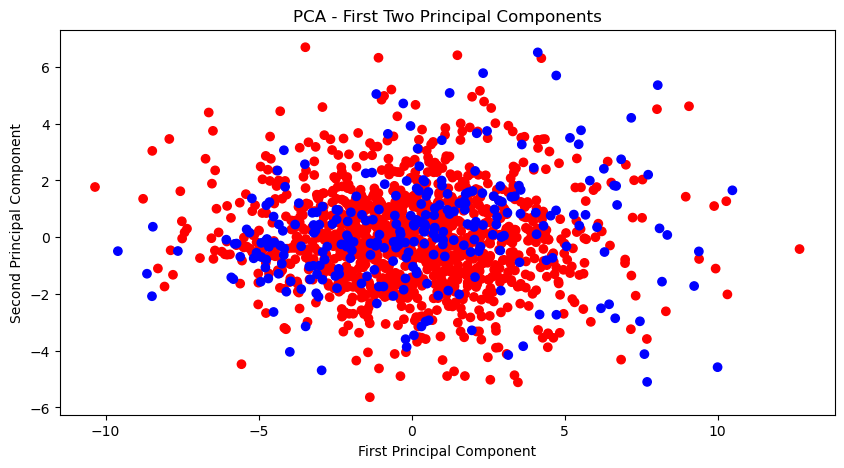

In [17]:
"""
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox

# Apply PCA
pca = PCA(n_components=2)  # We only need the first two PCs
X_test_pca = pca.fit_transform(X_test)

# Map the labels to colors
color_map = {0: 'blue', 1: 'red'}
colors = [color_map[label] for label in Y_test]

# Create a scatter plot colored by Y_test
plt.figure(figsize=(10,5))
scatter = plt.scatter(X_test_pca[:, 0],X_valid_pca[:, 1], c=colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA - First Two Principal Components')

# Add a color bar
#plt.colorbar(scatter)

# Annotate N random images
N = 10  # Number of images to annotate
indices = np.random.choice(X_test.shape[0], size=N, replace=False)  # Randomly select N indices
ax = plt.gca()
"""
"""
size=24
for i in indices:
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(X_test[i].reshape(size, size, 3), zoom=0.5),  # Reshape the flattened image
       X_valid_pca[i]
    )
    ax.add_artist(imagebox)
"""
# plt.show()


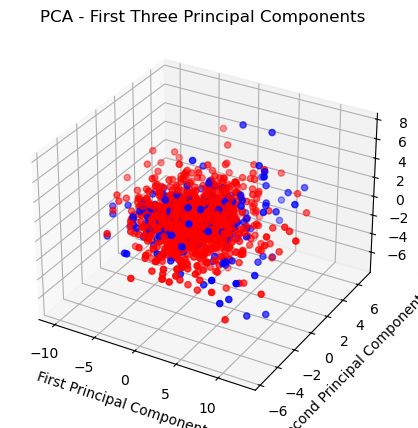

In [18]:
"""
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox

# Apply PCA
pca = PCA(n_components=3)  # Now we need the first three PCs
X_test_pca = pca.fit_transform(X_test)

# Map the labels to colors
color_map = {0: 'blue', 1: 'red'}
colors = [color_map[label] for label in Y_test]

# Create a scatter plot colored by Y_train
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_pca[:, 0],X_valid_pca[:, 1],X_valid_pca[:, 2], c=colors)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
plt.title('PCA - First Three Principal Components')

# Add a color bar
#plt.colorbar(scatter)

# Annotate N random images
N = 10  # Number of images to annotate
indices = np.random.choice(X_test.shape[0], size=N, replace=False)  # Randomly select N indices

plt.show()
""";

In [19]:
## Prediction

In [20]:
# Now make our predictions...

X = test_df[(test_df.type == 'fire') | (test_df.type == 'flood')]
X = X['image'].to_list()
X = np.array([cv2.resize(img, (180, 180)) for img in X])

# Transform the test data
X_pca = pca.transform(X)

# Make predictions
Y_pred = clf.predict(X_pca)

ValueError: Found array with dim 4. PCA expected <= 2.

In [ ]:
assert False, 'all stop.'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D layer (1st)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 89 * 89, 64)

        # Conv2D layer (2nd)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc2 = nn.Linear(32 * 43 * 43, 64)

        # Conv2D layer (3rd)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc3 = nn.Linear(32 * 20 * 20, 64)

        # Dense layer with linear activation for regression
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        # Apply layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = F.dropout(F.relu(self.fc1(x.view(x.size(0), -1))), 0.2)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = F.dropout(F.relu(self.fc2(x.view(x.size(0), -1))), 0.2)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = F.dropout(F.relu(self.fc3(x.view(x.size(0), -1))), 0.2)

        x = self.fc4(x)
        return x

# Instantiate the model
model = Net()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Define the custom activation function
def custom_activation(y):
    return (y > 0).int()

# Train the model
model.train()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    #for inputs, labels in zip(X_train, Y_train):
    # get the inputs; data is a list of [inputs, labels]
    #inputs, labels = data
    inputs, labels = X_train, Y_train

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 132 == 131:    # print every 132 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 132))
        running_loss = 0.0

print('Finished Training')

# Switch to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    prediction = model(X_test)
    prediction = torch.squeeze(custom_activation(prediction))  # sometimes you just want to hug and squeeze your tensors
    actual = custom_activation(Y_test)
